In [1]:
!pip install pip3-autoremove
!pip-autoremove torch torchvision torchaudio -y
!pip install torch torchvision torchaudio xformers --index-url https://download.pytorch.org/whl/cu121
!pip install unsloth

dill 0.3.8 is installed but dill<0.3.2,>=0.3.1.1 is required
Redoing requirement with just package name...
cloudpickle 3.0.0 is installed but cloudpickle~=2.2.1 is required
Redoing requirement with just package name...
numpy 1.26.4 is installed but numpy<1.25.0,>=1.14.3 is required
Redoing requirement with just package name...
pyarrow 16.1.0 is installed but pyarrow<10.0.0,>=3.0.0 is required
Redoing requirement with just package name...
jupyterlab 4.2.5 is installed but jupyterlab~=3.6.0 is required
Redoing requirement with just package name...
google-cloud-bigquery 2.34.4 is installed but google-cloud-bigquery[bqstorage,pandas]>=3.10.0 is required
Redoing requirement with just package name...
google-cloud-storage 1.44.0 is installed but google-cloud-storage>=2.0.0 is required
Redoing requirement with just package name...
pandas 2.2.2 is installed but pandas<2.1.4,>=1.5.0 is required
Redoing requirement with just package name...
botocore 1.35.23 is installed but botocore<1.30.0,>=1.29

In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 2x faster
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # 4bit for 405b!
    "unsloth/Mistral-Small-Instruct-2409",     # Mistral 22b 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!

    "unsloth/Llama-3.2-1B-bnb-4bit",           # NEW! Llama 3.2 models
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B-Instruct", # or choose "unsloth/Llama-3.2-1B-Instruct"
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.11.7: Fast Llama patching. Transformers = 4.46.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.741 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.11.7 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [4]:
import pandas as pd
from unsloth.chat_templates import get_chat_template, standardize_sharegpt
from datasets import load_dataset
from datasets import Dataset
# Load your dataset from the CSV file
df = pd.read_csv("/kaggle/input/iiitn-disha/iiitn.csv")

# Transform each row into a conversation format
df['conversations'] = df.apply(lambda row: [
    {"from": "human", "value": row['Name']},
    {"from": "gpt", "value": row['Details']}
], axis=1)

# Select only the `conversations` column
df = df[['conversations']]

# Convert the modified DataFrame to a Hugging Face Dataset
dataset = Dataset.from_pandas(df)

# Verify the structure of the dataset
print(dataset[0])  # Print the first item to see the format



{'conversations': [{'from': 'human', 'value': 'cse_Dr_Prerna_Mishra'}, {'from': 'gpt', 'value': '{\n"name": "Dr Prerna Mishra",\n"department": "Computer Science and Engineering",\n"position": "Adjunct Assistant Professor",\n"phone_no": "9834485669",\n"email": "pmishra@iiitn.ac.in",\n"joining_date": "03-01-2023",\n"education": [],\n"teaching_experience": [\n{\n"institution": "Indian Institute of Information Technology Nagpur",\n"position": "Adjunct Assistant Professor",\n"start_date": "03-01-2023",\n"end_date": "NA"\n}\n],\n"industrial_experience": [],\n"laboratory_development": [],\n"areas_of_interest": [],\n"projects": [],\n"publications": {},\n"supervision": {\n"pg_dissertation": "NA",\n"ug_dissertation": "NA",\n"phd_dissertation": "NA",\n"mtech_dissertation": "NA"},\n"fellowships": []\n}'}]}


In [5]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",
)

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }
pass


In [6]:
from unsloth.chat_templates import standardize_sharegpt
dataset = standardize_sharegpt(dataset)
dataset = dataset.map(formatting_prompts_func, batched = True,)

Standardizing format:   0%|          | 0/222 [00:00<?, ? examples/s]

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

In [7]:
dataset[5]["conversations"]

[{'content': 'cse_Ms._Madhuri_Dubey', 'role': 'user'},
 {'content': '{\n"name": "Ms. Madhuri Dubey",\n"department": "Computer Science and Engineering",\n"position": "Adjunct Assistant Professor",\n"phone_no": "9637073939",\n"email": "mdubey@iiitn.ac.in",\n"joining_date": "10-07-2023",\n"education": [\n{\n"degree_year": "2012",\n"degree": "U.G.",\n"college_name": "RTMNU",\n"university": "RTMNU"\n},\n{\n"degree_year": "2014",\n"degree": "P.G.",\n"college_name": "GHRCE",\n"university": "RTMNU"\n},\n{\n"degree_year": "2024",\n"degree": "PH.D",\n"college_name": "IIIT NAGPUR",\n"university": "IIIT"\n}],\n"teaching_experience": [\n{\n"institution": "Indian Institute of Information Technology Nagpur",\n"position": "Adjunct Assistant Professor",\n"start_date": "10-07-2023",\n"end_date": "NA"\n}\n],\n"industrial_experience": [],\n"laboratory_development": [],\n"areas_of_interest": [],\n"projects": [\n{\n"title": "Group Message Privacy and Data Sharing",\n"funding_agency": "NA",\n"role": "NA",\n"

In [8]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 4,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        num_train_epochs=50,
        learning_rate = 0.001,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Map (num_proc=2):   0%|          | 0/222 [00:00<?, ? examples/s]

In [9]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
    response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
)

Map:   0%|          | 0/222 [00:00<?, ? examples/s]

In [10]:
tokenizer.decode(trainer.train_dataset[5]["input_ids"])

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\ncse_Ms._Madhuri_Dubey<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n{\n"name": "Ms. Madhuri Dubey",\n"department": "Computer Science and Engineering",\n"position": "Adjunct Assistant Professor",\n"phone_no": "9637073939",\n"email": "mdubey@iiitn.ac.in",\n"joining_date": "10-07-2023",\n"education": [\n{\n"degree_year": "2012",\n"degree": "U.G.",\n"college_name": "RTMNU",\n"university": "RTMNU"\n},\n{\n"degree_year": "2014",\n"degree": "P.G.",\n"college_name": "GHRCE",\n"university": "RTMNU"\n},\n{\n"degree_year": "2024",\n"degree": "PH.D",\n"college_name": "IIIT NAGPUR",\n"university": "IIIT"\n}],\n"teaching_experience": [\n{\n"institution": "Indian Institute of Information Technology Nagpur",\n"position": "Adjunct Assistant Professor",\n"start_date": "10-07-2023",\n"end_date": "NA"\n}\n],\n"i

In [11]:
space = tokenizer(" ", add_special_tokens = False).input_ids[0]
tokenizer.decode([space if x == -100 else x for x in trainer.train_dataset[5]["labels"]])

'                                             \n\n{\n"name": "Ms. Madhuri Dubey",\n"department": "Computer Science and Engineering",\n"position": "Adjunct Assistant Professor",\n"phone_no": "9637073939",\n"email": "mdubey@iiitn.ac.in",\n"joining_date": "10-07-2023",\n"education": [\n{\n"degree_year": "2012",\n"degree": "U.G.",\n"college_name": "RTMNU",\n"university": "RTMNU"\n},\n{\n"degree_year": "2014",\n"degree": "P.G.",\n"college_name": "GHRCE",\n"university": "RTMNU"\n},\n{\n"degree_year": "2024",\n"degree": "PH.D",\n"college_name": "IIIT NAGPUR",\n"university": "IIIT"\n}],\n"teaching_experience": [\n{\n"institution": "Indian Institute of Information Technology Nagpur",\n"position": "Adjunct Assistant Professor",\n"start_date": "10-07-2023",\n"end_date": "NA"\n}\n],\n"industrial_experience": [],\n"laboratory_development": [],\n"areas_of_interest": [],\n"projects": [\n{\n"title": "Group Message Privacy and Data Sharing",\n"funding_agency": "NA",\n"role": "NA",\n"start_date": "NA",\

In [12]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
2.635 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 222 | Num Epochs = 50
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 4
\        /    Total batch size = 16 | Total steps = 700
 "-____-"     Number of trainable parameters = 24,313,856


Step,Training Loss
1,1.442300
2,1.649500
3,1.557800
4,1.480200
5,1.347800
6,1.184600
7,1.318700
8,1.332100
9,1.098800
10,1.136500


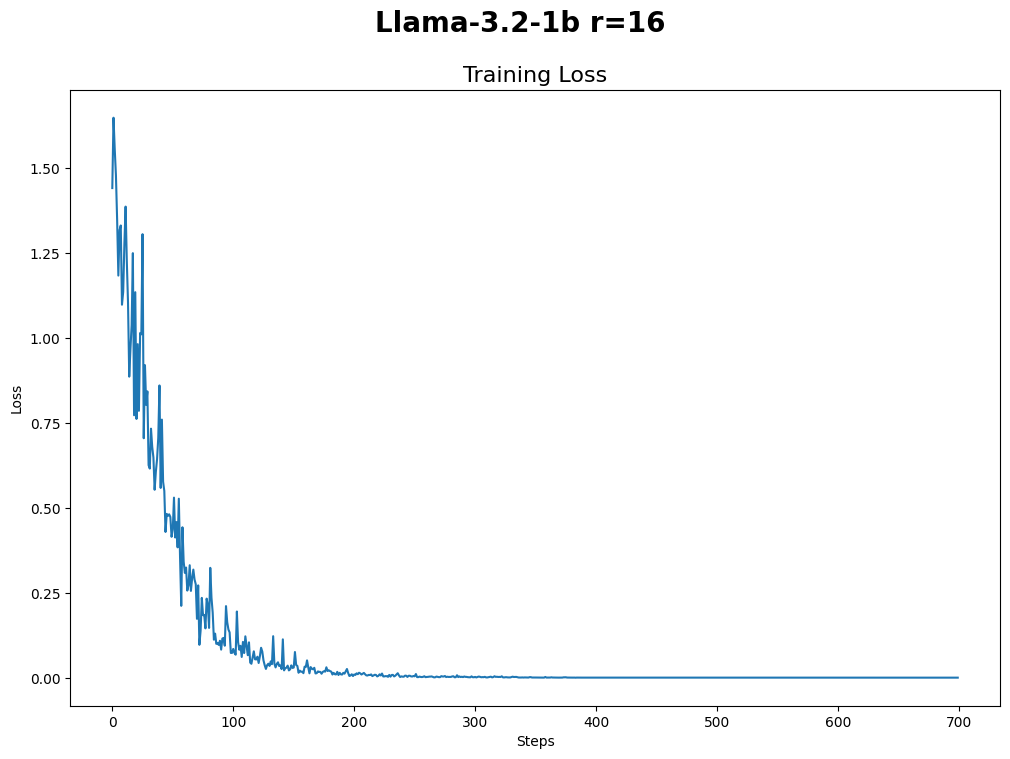

In [38]:
import matplotlib.pyplot as plt

# Extract the training losses from the log history
losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]

# Create the figure with larger size
plt.figure(figsize=(12, 8))  # Adjust the width and height (in inches)

# Plotting the loss curve
plt.plot(losses)

# Adding a heading for the figure
plt.suptitle("Llama-3.2-1b r=16", fontsize=20, fontweight='bold')

# Adding the title, axis labels, and displaying the plot
plt.title("Training Loss", fontsize=16)
plt.xlabel("Steps", fontsize=10)
plt.ylabel("Loss", fontsize=10)

# Display the plot
plt.show()


In [26]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

13974.5454 seconds used for training.
232.91 minutes used for training.
Peak reserved memory = 9.113 GB.
Peak reserved memory for training = 6.478 GB.
Peak reserved memory % of max memory = 61.821 %.
Peak reserved memory for training % of max memory = 43.945 %.


In [16]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"role": "user", "content": "Dr. Nishat Afshan Ansari"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = 2000, use_cache = True,
                         temperature = 0.1, min_p = 0.1)
tokenizer.batch_decode(outputs)

['<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nDr. Nishat Afshan Ansari<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n{\n"name": "Dr. Nishat Afshan Ansari",\n"department": "Computer Science and Engineering",\n"position": "Chairman/Head of Department",\n"phone_no": "9766223703",\n"email": "nishat.ansari@iiitn.ac.in",\n"joining_date": "July 2019",\n"education": [\n{\n"degree_year": "2009",\n"college_name": "Visvesvaraya National Institute of Technology",\n"university": "Visvesvaraya National Institute of Technology",\n"degree": "M.Tech.",\n"specialization": "CSE"\n},\n{\n"degree_year": "NA",\n"college_name": "Goverment College of Engineering Amravati",\n"university": "NA",\n"degree": "B.E.",\n"specialization": "CSE"\n}\n],\n"teaching_experience": [\n{\n"institution": "Indian Institute of Information Technology Nagpur","position": "Assistan

In [17]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"role": "user", "content": "Phd admission details"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 2000,
                   use_cache = True, temperature = 0.5, min_p = 0.1)

{
"PhD_Program": {
"Categories": {
"Industry_Candidates": [
{
"Type": "Extern",
"Code": "EX-I",
"Description": "Extern Candidate from Industry"
},
{
"Type": "Intern",
"Code": "IN-IS",
"Description": "Intern Sponsored Candidate from Industry"
}
],
"Academic_Institution_Candidates": [
{
"Type": "Extern",
"Code": "EX-A",
"Description": "Self-financed Candidate from Academic Institutions"
},
{
"Type": "Intern",
"Code": "IN-AS",
"Description": "Intern Sponsored Candidate from Academic Institutions"
}],
"Other_Candidates": [
{
"Type": "Intern",
"Code": "IN-U",
"Description": "Intern Self-Sponsored Candidate"
},
{
"Type": "Intern",
"Code": "IN-ES",
"Description": "Intern externally funded or Project Staff Candidate"
}
]
},
"Regulations": "The Ph.D. program operates under the Academic Regulations of the
Institute. Refer to the PhD Rule Book for academic regulations and details.",
"Admission_Modality": {
"Description": "Focuses on IT Industry problems, fostering Industry-Academia
"Rejection_Cri

In [18]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

In [27]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

import time
messages = [
    {"role": "user", "content": "Give me timetable of Lab2"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")
print("Give me timetable of Lab2")
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
start_time = time.time()
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 1000,
                   use_cache = True, temperature = 0.1, min_p = 0.1)
end_time = time.time()
response_time = end_time - start_time
print(f"Response time: {response_time:.2f} seconds")

Give me timetable of Lab2
{
"lab_name": "Lab2",
"schedule": {
"monday": {},
"tuesday": {},
"wednesday": {
"14-16": "DBMS Lab-CSE-A2-V"
},
"thursday": {
"14-16": "OOPS Lab-CSE-HCI-B2-III"
},
"friday": {}
},
"additional_info": {}
}<|eot_id|>
Response time: 4.93 seconds


In [39]:
df.iloc[186]["conversations"]

[{'from': 'human', 'value': 'timetable- Lab2'},
 {'from': 'gpt',
  'value': '{\n"lab_name": "Lab2",\n"schedule": {\n"monday": {},\n"tuesday": {},\n"wednesday": {\n"14-16": "DBMS Lab-CSE-A2-V"\n},\n"thursday": {\n"14-16": "OOPS Lab-CSE-HCI-B2-III"\n},\n"friday": {}\n},\n"additional_info": {}\n}'}]